In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
import math
import scipy.stats as stats

dl = DataLib("SignalData")

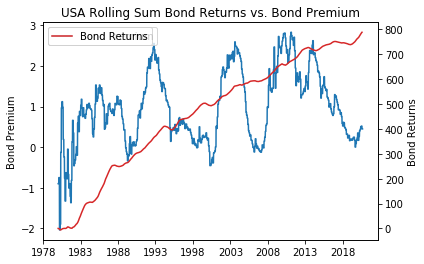

In [159]:
LongRates = dl.pull('LongRates')
ShortRates = dl.pull('ShortRates')
BondIndex = dl.pull('BondRetIdx/LocalFX')

WEEKDAYS_IN_YEAR = 261


# Bond Returns rolling sum 
def BondReturnMethod(country):
    return BondIndex[country].pct_change().rolling(WEEKDAYS_IN_YEAR, min_periods=0).sum()

# Bond Premium which is the LongRates minus ShortRates  
LongMinusShortRates = LongRates - ShortRates
dl.write_data("LongMinusShortRates", LongMinusShortRates)

# Normally we expect greater returns if bond premiums are higher; we would go long in a situation where bond premiums
# are high 
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Bond Premium'
ax1.plot(LongMinusShortRates['USA'].resample('B').ffill().to_timestamp(), color = 'tab:blue', label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend(loc=2)
ax2_label = 'Bond Returns'
ax2.plot(BondReturnMethod('USA').to_timestamp().cumsum(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title('USA Rolling Sum Bond Returns vs. Bond Premium')
plt.show()

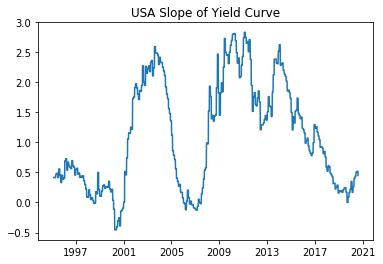

In [265]:
plt.plot(LongMinusShortRates['USA'].resample('B').ffill().loc['1995-03-01':'2020-08-03'].to_timestamp())
plt.title('USA Slope of Yield Curve')

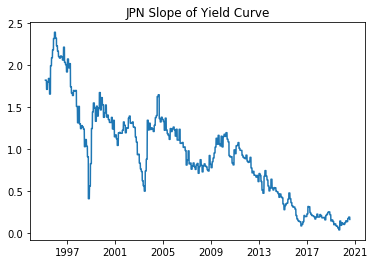

In [266]:
plt.plot(LongMinusShortRates['JPN'].resample('B').ffill().loc['1995-03-01':'2020-08-03'].to_timestamp())
plt.title('JPN Slope of Yield Curve')

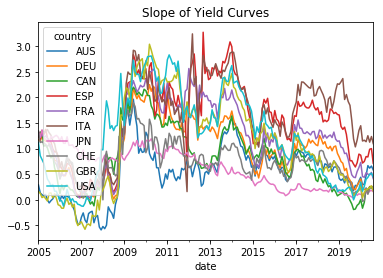

In [166]:
LongMinusShortRates.resample('M').last().to_timestamp().loc['2005':'2020'].plot()
plt.title('Slope of Yield Curves')

In [191]:
# Function that inputs BondPremium percent changes and outputs a standardized and normalized signal 
# for the last day of the percent changes in the datastream. 

def Signal(data, country):
    
    data = data[country]
    rescaled_data = []
    standardized_data = stats.zscore(data)
    minimum = min(standardized_data)
    maximum = max(standardized_data)
    
    for i in range(len(standardized_data)):
        new_x = (2 *(standardized_data[i]-minimum))/(maximum - minimum) - 1
        rescaled_data.append(new_x)
    
    return rescaled_data

#Signal(df_bondpremium, 'USA')

In [187]:
# Trying to do the same but over a rolling timeframe for minimum and maximums 

def SignalRolling(data, country):
    
    data = data[country]
    
    rescaled_data = []
    standardized_data = stats.zscore(data.rolling(WEEKDAYS_IN_YEAR, min_periods=0).mean())
    
    for i in range(len(standardized_data)):
            new_x = math.tanh(standardized_data[i])
            rescaled_data.append(new_x)
            
    
    return rescaled_data


#SignalRolling(df_bondpremium, 'USA')

In [195]:
df_bondpremium = pd.DataFrame(LongMinusShortRates.shift(1).resample('B').ffill().dropna())
df_bondpremium['RollingSig USA'] = SignalRolling(df_bondpremium, 'USA')
df_bondpremium['RollingSig JPN'] = SignalRolling(df_bondpremium, 'JPN')
df_bondpremium['RollingSig CHE'] = SignalRolling(df_bondpremium, 'CHE')
df_bondpremium['RollingSig AUS'] = SignalRolling(df_bondpremium, 'AUS')
df_bondpremium['RollingSig FRA'] = SignalRolling(df_bondpremium, 'FRA')
df_bondpremium['RollingSig ITA'] = SignalRolling(df_bondpremium, 'ITA')
df_bondpremium['RollingSig ESP'] = SignalRolling(df_bondpremium, 'ESP')
df_bondpremium['RollingSig CAN'] = SignalRolling(df_bondpremium, 'CAN')
df_bondpremium['RollingSig DEU'] = SignalRolling(df_bondpremium, 'DEU')
df_bondpremium['RollingSig GBR'] = SignalRolling(df_bondpremium, 'GBR')
df_bondpremium['NOTRollingSig USA'] = Signal(df_bondpremium, 'USA')
df_bondpremium['NOTRollingSig JPN'] = Signal(df_bondpremium, 'JPN')



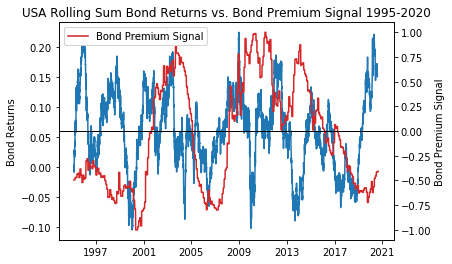

In [196]:
# Comparing bond returns and indicator signal in USA

# Plot of cumsum of bond returns and signal indicator for bond premium 
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Bond Returns'
ax1.plot(BondReturnMethod('USA').loc['1995-03':].to_timestamp(), color = 'tab:blue', label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend(loc=2)
ax2_label = 'Bond Premium Signal'
ax2.plot(df_bondpremium['NOTRollingSig USA'].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.axhline(linewidth=1, color='black')
ax2.legend()
plt.title('USA Rolling Sum Bond Returns vs. Bond Premium Signal 1995-2020')
plt.show()

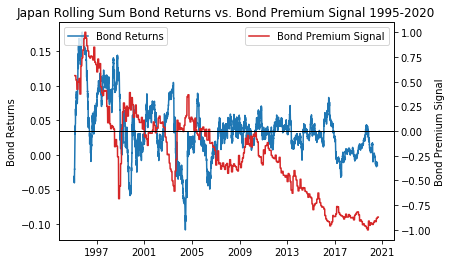

In [197]:
# Comparing bond returns and indicator signal in JPN

# Plot of cumsum of bond returns and signal indicator for bond premium 
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Bond Returns'
ax1.plot(BondReturnMethod('JPN').loc['1995-02':].to_timestamp(), color = 'tab:blue', label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend(loc=2)
ax2_label = 'Bond Premium Signal'
ax2.plot(df_bondpremium['NOTRollingSig JPN'].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.axhline(linewidth=1, color='black')
ax2.legend()
plt.title('Japan Rolling Sum Bond Returns vs. Bond Premium Signal 1995-2020')
plt.show()

# Thoughts for calculating P&L 

Ok so we want to look a bit in the future --> some sort of lag when calculating. 

Aka if now our signal says -1 we want to short 100% of our bonds. 


In [258]:
# PnL calculations in the US if following signal

# Originally doing 

BondIndexDiffJPN = BondIndex['JPN'].pct_change().shift(1).loc['1995-03-01':'2020-08-03']
SignalBondPremiumJPN = df_bondpremium['RollingSig JPN']

BondIndexDiffUSA = BondIndex['USA'].pct_change().shift(1).loc['1995-03-01':'2020-08-03']
SignalBondPremiumUSA = df_bondpremium['RollingSig USA']


def CountryPNL(bondindex, signal):
    PnL = 0
    PnL_plot = []
    prev = 0 

    for i in range(len(bondindex)):
        if np.isnan(bondindex[i]) == False:
            prev = bondindex[i]* (1+signal[i])
            PnL += bondindex[i]* (1+signal[i])
        else:
            PnL_plot.append(prev)
            continue 
        PnL_plot.append(PnL)

    return PnL, PnL_plot

JPN_PnL, JPN_PnL_plot = CountryPNL(BondIndexDiffJPN, SignalBondPremiumJPN)
USA_PnL, USA_PnL_plot = CountryPNL(BondIndexDiffUSA, SignalBondPremiumUSA)

print('Japan PNL', JPN_PnL)
print('USA PNL', USA_PnL)

Japan PNL 1.4589906285204957
USA PNL 1.3799297437009719


In [275]:
# Buy and hold seems to perform much better! -- is this how we approach buy and hold across world?

def BaseCountryPNL(bondindex):
    Base_PnL = 0
    Base_PnL_plot = []
    prev=0

    for i in range(len(bondindex)):
        if np.isnan(bondindex[i]) == False:
            prev = bondindex[i]
            Base_PnL += bondindex[i]
        else:
            Base_PnL_plot.append(prev)
            continue
        Base_PnL_plot.append(Base_PnL)
    return Base_PnL, Base_PnL_plot

USA_Base_PnL, USA_Base_PnL_plot = BaseCountryPNL(BondIndexDiffUSA)
JPN_Base_PnL, JPN_Base_PnL_plot = BaseCountryPNL(BondIndexDiffJPN)


print('Japan Buy&Hold PNL', JPN_Base_PnL)
print('USA Buy&Hold PNL', USA_Base_PnL)


Japan Buy&Hold PNL 0.9943515665644133
USA Buy&Hold PNL 1.6337127795892767


In [274]:


BondIndex.pct_change().shift(1).loc['1995-03-01':'2020-08-03'].dropna().sum()


country
AUS    2.043147
DEU    1.577523
CAN    1.731925
ESP    2.139892
FRA    1.703714
ITA    2.172799
JPN    0.876690
CHE    1.133267
GBR    1.797929
USA    1.546995
dtype: float64

In [260]:
mydates = pd.date_range('1995-03-01', '2020-08-03', freq='B').tolist()

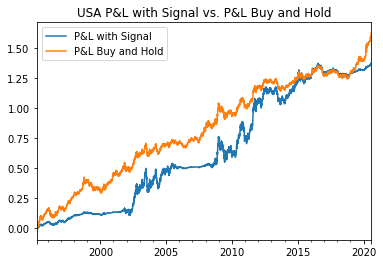

In [261]:
df_pnl = pd.DataFrame(index=mydates)
df_pnl['US PnL with Signal'] = USA_PnL_plot
df_pnl['US PnL with NO Signal'] = USA_Base_PnL_plot


df_pnl['US PnL with Signal'].plot(label='P&L with Signal')
df_pnl['US PnL with NO Signal'].plot(label='P&L Buy and Hold')
plt.legend()
plt.title('USA P&L with Signal vs. P&L Buy and Hold')

In [262]:
# Average returns with signal 
SigAvg = df_pnl['US PnL with Signal'].mean()
SigStd = df_pnl['US PnL with Signal'].std()

# Lower risk adjusted returns with signal 
SigAvg/SigStd

1.389312113781228

In [263]:
# Average returns without signal 
noSigAvg = df_pnl['US PnL with NO Signal'].mean()
noSigStd =df_pnl['US PnL with NO Signal'].std()

# Higher risk adjusted returns without signal 
noSigAvg/noSigStd

1.9966834449415352

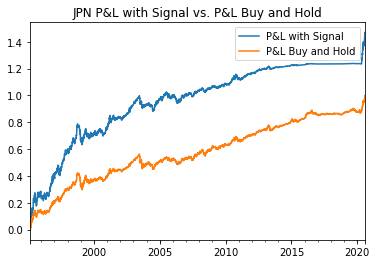

In [37]:
df_pnl['JPN PnL with Signal'] = JPN_PnL_plot
df_pnl['JPN PnL with NO Signal'] = JPN_Base_PnL_plot


df_pnl['JPN PnL with Signal'].plot(label='P&L with Signal')
df_pnl['JPN PnL with NO Signal'].plot(label='P&L Buy and Hold')
plt.legend()
plt.title('JPN P&L with Signal vs. P&L Buy and Hold')

In [38]:
# Average returns with signal 
SigAvg = df_pnl['JPN PnL with Signal'].mean()
SigStd = df_pnl['JPN PnL with Signal'].std()

# Higher risk adjusted returns with signal 
SigAvg/SigStd

3.3471703543036733

In [39]:
# Average returns without signal 
noSigAvg = df_pnl['JPN PnL with NO Signal'].mean()
noSigStd =df_pnl['JPN PnL with NO Signal'].std()

# Lower risk adjusted returns without signal 
noSigAvg/noSigStd

2.5993382197602033

# Standardizing across rows

In [148]:
# Instead here I am standardizing across rows 
standardizedRow = np.apply_along_axis(stats.zscore, 1, LongMinusShortRates.shift(1).resample('B').ffill().loc['1995-03-01':'2020-08-03'])

normedRow = np.apply_along_axis(np.tanh, 1, standardizedRow)


df_row_zscore = pd.DataFrame(standardizedRow)

df_row_zscoreNorm = pd.DataFrame(normedRow)


# Matrix of normalized country bond premiums 
row_zscore_matrix = df_row_zscore.to_numpy()
df_row_zscoreNorm_matrix = df_row_zscoreNorm.to_numpy()



In [72]:
df_returns = pd.DataFrame(BondIndex[countries[j]].pct_change().shift(1).loc['1995-03-01':'2020-08-03'])

In [91]:
# profits and loss across countries!!
# yay indicator seems to be slightly better than just holding normal bonds 

# when normalized and then standardized it performs very poorly 
# when standardized it performs quite well

# Taking a diff between countries --> standardized across a row 

Standardized = row_zscore_matrix

#BondIndexCountries = BondIndex.resample('M').last().pct_change().shift(1)

countries = ['AUS','DEU','CAN','ESP','FRA','ITA','JPN','CHE','GBR','USA']
PnLDeveloped_plot = []


PnLDeveloped = 0
for i in range(len(BondIndex.pct_change().shift(1).loc['1995-03-01':'2020-08-03'])):
    for j in range(len(countries)):
        PnLDeveloped += (1+Standardized[i][j])*(BondIndex[countries[j]].pct_change().shift(1).loc['1995-03-01':'2020-08-03']).iloc[i]
        
        
    PnLDeveloped_plot.append(PnLDeveloped)
      
print(PnLDeveloped)

17.503926609624493


In [116]:
# buying and holding developed world PNL 

Base_PnLDeveloped_plot = []

Base_PnLDeveloped = 0
#for i in range(len(Standardized)):
for j in range(len(countries)):

    Base_PnLDeveloped += (BondIndex[countries[j]].pct_change().shift(1).loc['1995-03-01':'2020-08-03'])

Base_PnLDeveloped_plot = (Base_PnLDeveloped.cumsum()).to_numpy()

print(Base_PnLDeveloped.sum())
        


16.72388158000009


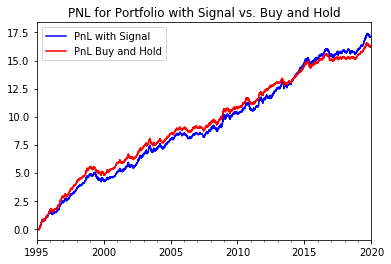

In [117]:
# Comparing different plots 

df_pnl_std = pd.DataFrame(index=mydates)
df_pnl_std['PnL with Signal'] = PnLDeveloped_plot
df_pnl_std['PnL with NO Signal'] = (Base_PnLDeveloped.cumsum()).to_numpy()


df_pnl_std['PnL with Signal'].plot(label='PnL with Signal', c='blue')
df_pnl_std['PnL with NO Signal'].plot(label='PnL Buy and Hold', c='red')
plt.xlim('1995', '2020')
plt.legend()
plt.title('PNL for Portfolio with Signal vs. Buy and Hold')

In [137]:
# HERE WE NORMALIZED 

Normalized = df_row_zscoreNorm_matrix



countries = ['AUS','DEU','CAN','ESP','FRA','ITA','JPN','CHE','GBR','USA']
PnLDevelopedNorm_plot = []


PnLDevelopedNorm = 0
for i in range(len(BondIndex.pct_change().shift(1).loc['1995-03-01':'2020-08-03'])):
    for j in range(len(countries)):
        PnLDevelopedNorm += (1+Normalized[i][j])*(BondIndex[countries[j]].pct_change().shift(1).loc['1995-03-01':'2020-08-03']).iloc[i]
        
        
    PnLDevelopedNorm_plot.append(PnLDevelopedNorm)
      
print(PnLDevelopedNorm)

17.292642497352023


In [136]:
# AGAIN NORMALIZED


Base_PnLDeveloped_plotNorm = []

Base_PnLDevelopedNorm = 0

for j in range(len(countries)):

    Base_PnLDevelopedNorm += (BondIndex[countries[j]].pct_change().shift(1).loc['1995-03-01':'2020-08-03'])

Base_PnLDeveloped_plotNorm = (Base_PnLDevelopedNorm.cumsum()).to_numpy()

print(Base_PnLDevelopedNorm.sum())

16.72388158000009


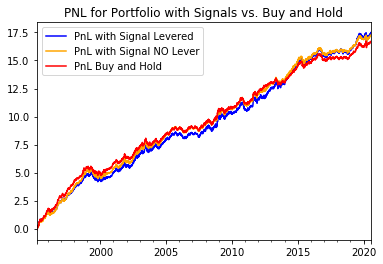

In [146]:

df_pnl_norm = pd.DataFrame(index=mydates)
df_pnl_norm['PnL with Signal Levered'] = PnLDeveloped_plot
df_pnl_norm['PnL with Signal NO Lever'] = PnLDevelopedNorm_plot
df_pnl_norm['PnL without Signal'] = (Base_PnLDeveloped.cumsum()).to_numpy()


df_pnl_norm['PnL with Signal Levered'].plot(label='PnL with Signal Levered', c='blue')
df_pnl_norm['PnL with Signal NO Lever'].plot(label='PnL with Signal NO Lever', c='orange')
df_pnl_norm['PnL without Signal'].plot(label='PnL Buy and Hold', c='red')
#plt.xlim('2005', '2020')
#plt.ylim(bottom=10, top=20)
plt.legend()
plt.title('PNL for Portfolio with Signals vs. Buy and Hold')

In [150]:
# Average returns with signal 
SigAvgPort = df_pnl_norm['PnL without Signal'].mean()
SigStdPort = df_pnl_norm['PnL without Signal'].std()

# Lower risk adjusted returns without signal 
SigAvgPort/SigStdPort

2.195042654490401

# CUT

In [ ]:
# PNL AFTER 2008 WITH SIGNAL
Standardized = row_zscore_matrix

countries = ['AUS','DEU','CAN','ESP','FRA','ITA','JPN','CHE','GBR','USA']

PnLDeveloped2 = 0
for i in range(len(BondIndex['USA'].pct_change().shift(1).loc[:'2008'])):
    for j in range(len(countries)):
        
        if np.isnan(Standardized[i][j]) == False:
            PnLDeveloped2 += (1+Standardized[i][j])*(BondIndex[countries[j]].pct_change().shift(1)).loc[:'2008'].iloc[i]
        else:
            continue
        
print(PnLDeveloped2)

In [ ]:
# PNL AFTER 2008 WITH NO SIGNAL
Standardized = row_zscore_matrix

countries = ['AUS','DEU','CAN','ESP','FRA','ITA','JPN','CHE','GBR','USA']

PnLDeveloped3 = 0
for i in range(len(BondIndex['USA'].pct_change().shift(1).loc[:'2008'])):
    for j in range(len(countries)):
        
        if np.isnan(Standardized[i][j]) == False:
            PnLDeveloped3 += (BondIndex[countries[j]].pct_change().shift(1)).loc[:'2008'].iloc[i]
        else:
            continue
        
print(PnLDeveloped3)

In [ ]:
len(BondIndex['USA'].pct_change().shift(1).loc[:'2008'])

In [ ]:
# Comparing different plots 
mydates2 = pd.date_range('1980-01-01', '2020-08-03', freq='B').tolist()

df_pnl_std = pd.DataFrame(index=mydates2)
df_pnl_std['PnL with Signal'] = PnLDeveloped_plot
df_pnl_std['PnL with NO Signal'] = Base_PnLDeveloped_plot


df_pnl_std['PnL with Signal'].plot(label='PnL with Signal', c='blue')
df_pnl_std['PnL with NO Signal'].plot(label='PnL Buy and Hold', c='red')
#plt.xlim('1995', '2020')
plt.legend()
plt.title('PNL for Portfolio with Signal vs. Buy and Hold')

In [123]:
# Average returns with signal 
SigAvgPort = df_pnl_std['PnL with Signal'].mean()
SigStdPort =df_pnl_std['PnL with Signal'].std()

# Lower risk adjusted returns without signal 
SigAvgPort/SigStdPort

1.9883281393623446

In [124]:
# Average returns without signal 
noSigAvgPort = df_pnl_std['PnL with NO Signal'].mean()
noSigStdPort =df_pnl_std['PnL with NO Signal'].std()

# Lower risk adjusted returns without signal 
noSigAvgPort/noSigStdPort

2.195042654490401